# Library

In [1]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import numpy as np

In [2]:
import glob
from astropy.table import Table

# Function

In [3]:
def tablize_sedinfo(path_sedinfo, models):
	infotbl = Table()
	infotbl['model'] = models
	
	with open(path_sedinfo, 'r') as f:
		for line in f:
			#	Find parameter row
			if line.startswith('PARNAMES: '):
				# print(line)
				headers = line.split()[1:]
				break
		#	Generate empty columns
		for header in headers:
			infotbl[header] = 0.0

		for ll, line in enumerate(f):
			if ll < len(infotbl):
				#	Values
				if line.startswith('SED:'):
					vals = line.split()[2:]
					for hh, header in enumerate(headers):
						infotbl[header][ll] = float(vals[hh])

	return infotbl


# Setting

- Model

In [15]:
typ = 'SNIax'
# typ = 'TDE'

In [16]:
models = sorted(glob.glob(f'../model/PLAsTiCC/{typ}/SIMSED.{typ}/*.fits'))
print(f"{len(models)} models found") 

1001 models found


- Information Table

In [17]:
path_sedinfo = f'../model/PLAsTiCC/{typ}/SIMSED.{typ}/SED.INFO'
infotbl = tablize_sedinfo(path_sedinfo, models)

- Test a single model

In [18]:
ii = 10
model = models[ii]
_intbl = Table.read(model)

indx = np.where(
    (_intbl['col1'] <= 30) &
    (_intbl['col2'] >= 2000) &
    (_intbl['col2'] <= 10000)
)

intbl = _intbl[indx]
phasearr = np.unique(intbl['col1'])
lamarr = np.unique(intbl['col2'])
number_of_unique_phase, number_of_unique_wavelength = len(phasearr), len(lamarr)
flux2darr = intbl['col3'].reshape(number_of_unique_phase, number_of_unique_wavelength)

print(f"Table length: {len(_intbl)} --> {len(intbl)}")

Table length: 112800 --> 22400


# Interpolation with RF

In [39]:
param_keys = infotbl.keys()[2:]
param_keys

['M_V', 't_rise', 'dm15B', 'dm15R']

In [20]:
X = []
y = []

# for mm, model in enumerate(infotbl['model'][:10]):
# for mm, model in enumerate(infotbl['model'][:]):
# for mm, model in enumerate(infotbl['model'][:100]):
for mm, model in enumerate(infotbl['model'][:]):
    _mdtbl = Table.read(model)

    indx = np.where(
        (_mdtbl['col1'] <= 30) &
        (_mdtbl['col2'] >= 2000) &
        (_mdtbl['col2'] <= 10000)
    )
    mdtbl = _mdtbl[indx]

    # param1 = infotbl['M_V'][mm]
    # param2 = infotbl['t_rise'][mm]
    # param3 = infotbl['dm15B'][mm]
    # param4 = infotbl['dm15R'][mm]
    # param5 = infotbl['phase'][mm]

    param_values = []
    for key in param_keys:
        param_values.append(infotbl[key][mm])

    # 해당 모델의 스펙트럼 데이터 추출
    model_spectrum = mdtbl['col3'].reshape(number_of_unique_phase, number_of_unique_wavelength)

    # 데이터 포인트 생성 및 추가
    for pp, param5 in enumerate(phasearr):
        _param_values = param_values.copy()
        _param_values.append(param5)
        X.append(_param_values)
        y.append(model_spectrum[pp])

In [21]:
# 데이터 변환
X = np.array(X)
y = np.array(y)

# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [22]:
# Random Forest 모델 생성 및 훈련
rf = RandomForestRegressor()
rf.fit(X_train, y_train)


RandomForestRegressor()

In [23]:
# 테스트 데이터에 대한 예측 수행
y_pred = rf.predict(X_test)

- 결정 계수 (Coefficient of Determination, R-squared): 예측값이 종속 변수의 변동성을 얼마나 잘 설명하는지를 나타내는 지표로, 0과 1 사이의 값을 가집니다. 1에 가까울수록 모델의 예측이 실제 데이터와 잘 일치합니다.


In [24]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# 평균 제곱 오차 (MSE) 계산
mse = mean_squared_error(y_test, y_pred)
print("평균 제곱 오차 (MSE):", mse)

# 평균 절대 오차 (MAE) 계산
mae = mean_absolute_error(y_test, y_pred)
print("평균 절대 오차 (MAE):", mae)

# 결정 계수 (R-squared) 계산
r2 = r2_score(y_test, y_pred)
print("결정 계수 (R-squared):", r2)

평균 제곱 오차 (MSE): 8.819946447881462e-07
평균 절대 오차 (MAE): 0.00022498005664518795
결정 계수 (R-squared): 0.997123310246319


# Test interpolation

In [25]:
ii = 10
new_param1 = infotbl['M_V'][ii]
new_param2 = infotbl['t_rise'][ii]
new_param3 = infotbl['dm15B'][ii]
new_param4 = infotbl['dm15R'][ii]
new_param5 = phasearr[25]

In [26]:
# 임의의 파라미터와 시간 설정
# new_param1 = 16.0
# new_param2 = 13.0
# new_param3 = 1.9
# new_param4 = 0.7
# new_param5 = 100.0

# 새로운 데이터 포인트 생성
new_data = np.array(
	[[new_param1, new_param2, new_param3, new_param4, new_param5,]]
	)

# 보강된 스펙트럼 예측
interpolated_spectrum = rf.predict(new_data)

# 결과 출력
# print("보강된 스펙트럼 플럭스:", interpolated_spectrum)

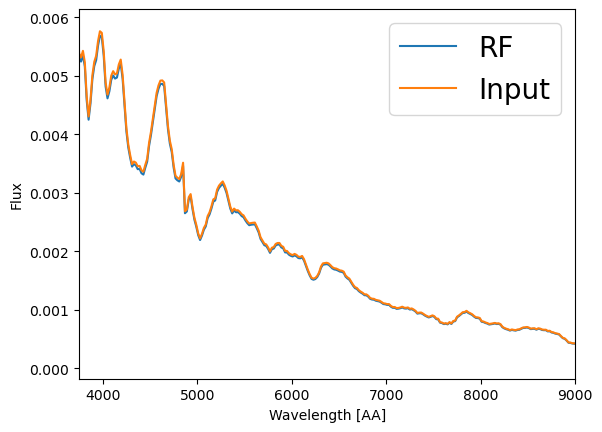

In [27]:
import matplotlib.pyplot as plt
plt.plot(lamarr, interpolated_spectrum[0], label='RF')
plt.plot(lamarr, flux2darr[25], label='Input')
# plt.plot(lamarr, 1e2*(interpolated_spectrum[0]-flux2darr[25])/interpolated_spectrum[0])
# plt.axhline(y=0.0, ls='--', color='grey', lw=3, alpha=0.5)
# plt.ylim([-5, +5])
plt.xlim([3750, 9000])
plt.xlabel('Wavelength [AA]')
plt.ylabel('Flux')
plt.legend(fontsize=20)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


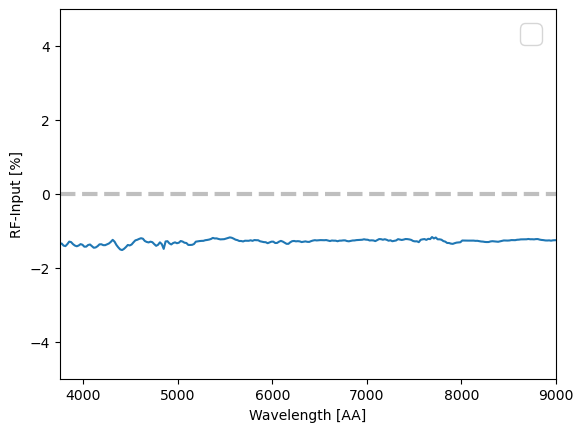

In [28]:
plt.plot(lamarr, 1e2*(interpolated_spectrum[0]-flux2darr[25])/interpolated_spectrum[0])
plt.axhline(y=0.0, ls='--', color='grey', lw=3, alpha=0.5)
plt.ylim([-5, +5])
plt.xlim([3750, 9000])
plt.xlabel('Wavelength [AA]')
plt.ylabel('RF-Input [%]')
plt.legend(fontsize=20)

In [31]:
# import os
# os.path.dirname(path_sedinfo)

'../model/PLAsTiCC/SNIax/SIMSED.SNIax'

In [32]:
# import pickle

# path_pickle = f'../model/PLAsTiCC/{typ}/rf_model.pkl'

# if path_pickle is not None:
# 	print(f"Dumping interpolator to {path_pickle}...")
# 	with open(path_pickle, 'wb') as f:
# 		pickle.dump(rf, f)

Dumping interpolator to ../model/PLAsTiCC/SNIax/rf_model.pkl...


# Function

In [43]:
def prepare_rf_train_data(infotbl, param_keys, phasearr, number_of_unique_phase, number_of_unique_wavelength, phase_upper=30., lam_lower=2000., lam_upper=10000.):
	X = []
	y = []

	for mm, model in enumerate(infotbl['model'][:]):
		_mdtbl = Table.read(model)

		indx = np.where(
			# (_mdtbl['col1'] <= 30) &
			# (_mdtbl['col2'] >= 2000) &
			# (_mdtbl['col2'] <= 10000)
			(_mdtbl['col1'] <= phase_upper) &
			(_mdtbl['col2'] >= lam_lower) &
			(_mdtbl['col2'] <= lam_upper)
		)
		mdtbl = _mdtbl[indx]

		# param1 = infotbl['M_V'][mm]
		# param2 = infotbl['t_rise'][mm]
		# param3 = infotbl['dm15B'][mm]
		# param4 = infotbl['dm15R'][mm]
		# param5 = infotbl['phase'][mm]

		param_values = []
		for key in param_keys:
			param_values.append(infotbl[key][mm])

		# 해당 모델의 스펙트럼 데이터 추출
		model_spectrum = mdtbl['col3'].reshape(number_of_unique_phase, number_of_unique_wavelength)

		# 데이터 포인트 생성 및 추가
		for pp, param5 in enumerate(phasearr):
			_param_values = param_values.copy()
			_param_values.append(param5)
			X.append(_param_values)
			y.append(model_spectrum[pp])
	return X, y

In [44]:
X, y = prepare_train_data(infotbl, param_keys, phasearr, number_of_unique_phase, number_of_unique_wavelength)